In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil
import Augmentor
from os import listdir
from os.path import isfile, join

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

/var/folders/sy/76hj9jm13334_1xqh0j2pbnm0000gn/T/ipykernel_38803/3985492883.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [6]:
data_in = 'data/'

all_lesions_dir = data_in + 'all_lesions/'
all_masks_dir = data_in + 'all_masks/'
all_labels_dir = data_in + 'all_labels/'

aug_lesions_dir = data_in + 'aug_lesions/'
aug_masks_dir = data_in + 'aug_masks/'
aug_labels_dir = data_in + 'aug_labels/'

## Data Augmentation

In [18]:
original_lesions = [f for f in listdir(all_lesions_dir) if isfile(join(all_lesions_dir, f))]
original_masks = [f for f in listdir(all_masks_dir) if isfile(join(all_masks_dir, f))]

In [21]:
filenames = [f[:-4] for f in original_lesions]

['ISIC_0032929',
 'ISIC_0026790',
 'ISIC_0028965',
 'ISIC_0024839',
 'ISIC_0032915',
 'ISIC_0024805',
 'ISIC_0029474',
 'ISIC_0032732',
 'ISIC_0033438',
 'ISIC_0032726',
 'ISIC_0032040',
 'ISIC_0031561',
 'ISIC_0033410',
 'ISIC_0030119',
 'ISIC_0025500',
 'ISIC_0033362',
 'ISIC_0026009',
 'ISIC_0026586',
 'ISIC_0034141',
 'ISIC_0029676',
 'ISIC_0026545',
 'ISIC_0031987',
 'ISIC_0024420',
 'ISIC_0030333',
 'ISIC_0031005',
 'ISIC_0033612',
 'ISIC_0033174',
 'ISIC_0024408',
 'ISIC_0025716',
 'ISIC_0027101',
 'ISIC_0025064',
 'ISIC_0033606',
 'ISIC_0027673',
 'ISIC_0025851',
 'ISIC_0025879',
 'ISIC_0029931',
 'ISIC_0024554',
 'ISIC_0030521',
 'ISIC_0029070',
 'ISIC_0031159',
 'ISIC_0032450',
 'ISIC_0027713',
 'ISIC_0028352',
 'ISIC_0032685',
 'ISIC_0030910',
 'ISIC_0032875',
 'ISIC_0024971',
 'ISIC_0029272',
 'ISIC_0030723',
 'ISIC_0024756',
 'ISIC_0032134',
 'ISIC_0027277',
 'ISIC_0028622',
 'ISIC_0025312',
 'ISIC_0033570',
 'ISIC_0033216',
 'ISIC_0031401',
 'ISIC_0027263',
 'ISIC_0025313

In [39]:
# https://www.geeksforgeeks.org/python-data-augmentation/

# Initialising the ImageDataGenerator class.
# We will pass in the augmentation parameters in the constructor.
datagen = ImageDataGenerator(
        rotation_range = 60,
        shear_range = 0.5,
        horizontal_flip = True,
        vertical_flip = True)

for f in filenames:
    img_lesion = load_img(all_lesions_dir + f + '.jpg')  
    x_lesion = img_to_array(img_lesion) 
    # Reshape the input image 
    x_lesion = x_lesion.reshape((1, ) + x_lesion.shape)

    img_mask = load_img(all_masks_dir + f + '.png')  
    x_mask = img_to_array(img_mask) 
    # Reshape the input image 
    x_mask = x_mask.reshape((1, ) + x_mask.shape)

    
    i = 0

    # generate 5 new augmented images 
    for batch in datagen.flow(x_lesion, batch_size = 1, save_to_dir =data_in + 'aug_lesions', save_prefix ='aug_'+ f, save_format ='jpeg', seed=23):
        i += 1
        if i > 5: 
            break

    i = 0
    for batch in datagen.flow(x_mask, batch_size = 1, save_to_dir =data_in + 'aug_masks', save_prefix ='aug_' + f, save_format ='jpeg', seed=23):
        i += 1
        if i > 5: 
            break

## Label Calculation

In [229]:
rows_list = []

# Iterate through all masks and run the extract function
# for image in listdir(aug_masks_dir):
for image in listdir(all_masks_dir):
    mask = cv2.imread(all_masks_dir + image)

    try:
        labels = extract(mask)
    except:
        print("error with image: " + image)
        continue

    labels['image'] = image
    rows_list.append(labels)

df_labels = pd.DataFrame(rows_list)               

error with image: ISIC_0024623.png
error with image: ISIC_0026556.png
error with image: ISIC_0026042.png
error with image: ISIC_0029819.png


In [230]:
# df_labels.to_csv(all_labels_dir + 'labels.csv')

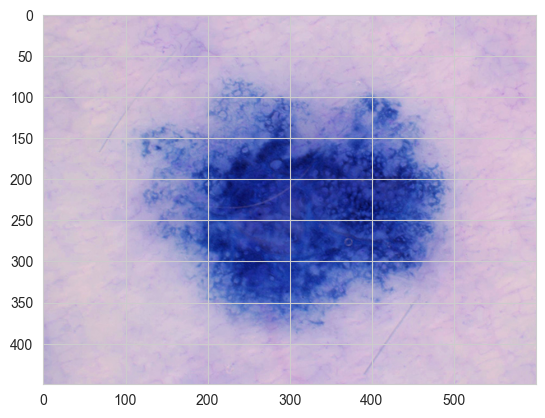

In [87]:
plt.imshow(cv2.imread(all_lesions_dir + "ISIC_0028898.jpg"))
plt.show()

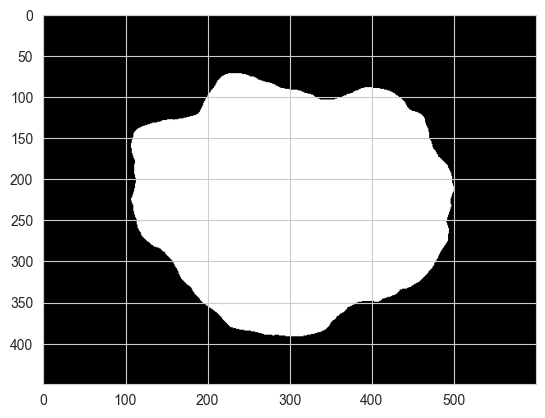

In [86]:
plt.imshow(cv2.imread(all_masks_dir + "ISIC_0028898.png"))
plt.show()

In [214]:
# https://github.com/hadikhanhk786/melanoma-detection-python/blob/master/src/features.py

# Adapted to take in a mask and return asymmetry (horizantal and vertical) and border irregularity

# -*- coding: utf-8 -*-

# Also utilzied asymmetry calculation from: https://github.com/rishabhc32/skin-lesion-detection/blob/master/a-melanoma.py

"""
Methods to extract features (A, B, D) of a lesion.

Created on Tue Jun 06 11:29:16 2017

@author: ukalwa
"""
# third-party imports
# import cv2
# import numpy as np


def extract(mask):
    """
    This method extracts Asymmetry, Border, and Diamter features along with
    lesion area, centroid, and perimeter. Performs affine transformation

    :param image: 3-d numpy array of an RGB image
    :param mask: binary image of the lesion mask image
    :param contour: list of contour points of the lesion
    :return: a list of all the features along with area, centroid,
    perimeter of the lesion, and transformed image

    It has been adapted as part of my IAT 885 project to run directly on segmentation masks, as opposed
    to segmenting the actual lesion of the image first
    """

    gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    contours,hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)

    ellipse = cv2.fitEllipse(contour)
    ellipse_pnts = cv2.ellipse2Poly( (int(ellipse[0][0]),int(ellipse[0][1]) ) ,( int(ellipse[1][0]),int(ellipse[1][1]) ),int(ellipse[2]),0,360,1)
    a = cv2.matchShapes(contour, ellipse_pnts,1,0.0)
    
    moments = cv2.moments(contour)
    contour_area = cv2.countNonZero(gray)
    
    # try:
    contour_centroid = [int(moments['m10'] / moments['m00']),
                        int(moments['m01'] / moments['m00'])]
    contour_perimeter = cv2.arcLength(contour, True)

    # Get max and min diameter
    rect = cv2.fitEllipse(contour)
    (x, y) = rect[0]
    (w, h) = rect[1]
    angle = rect[2]

    if w < h:
        if angle < 90:
            angle -= 90
        else:
            angle += 90
    rows, cols, _ = mask.shape
    rot = cv2.getRotationMatrix2D((x, y), angle, 1)
    cos = np.abs(rot[0, 0])
    sin = np.abs(rot[0, 1])
    nW = int((rows * sin) + (cols * cos))
    nH = int((rows * cos) + (cols * sin))

    rot[0, 2] += (nW / 2) - cols / 2
    rot[1, 2] += (nH / 2) - rows / 2

    warp_mask = cv2.warpAffine(mask, rot, (nH, nW))
    warp_mask = cv2.cvtColor(warp_mask, cv2.COLOR_BGR2GRAY)

    cnts, hierarchy = cv2.findContours(warp_mask, cv2.RETR_TREE,
                                                cv2.CHAIN_APPROX_NONE)
    areas = [cv2.contourArea(c) for c in cnts]
    contour = cnts[np.argmax(areas)]
    xx, yy, nW, nH = cv2.boundingRect(contour)
    warp_mask = warp_mask[yy:yy + nH, xx:xx + nW]

    # get horizontal asymmetry
    flipContourHorizontal = cv2.flip(warp_mask, 1)
    flipContourVertical = cv2.flip(warp_mask, 0)

    diff_horizontal = cv2.compare(warp_mask, flipContourHorizontal,
                                  cv2.CV_8UC1)
    diff_vertical = cv2.compare(warp_mask, flipContourVertical,
                                cv2.CV_8UC1)

    diff_horizontal = cv2.bitwise_not(diff_horizontal)
    diff_vertical = cv2.bitwise_not(diff_vertical)

    h_asym = cv2.countNonZero(diff_horizontal)
    v_asym = cv2.countNonZero(diff_vertical)

    return {'area': int(contour_area),
            'centroid': contour_centroid,
             'perimeter': int(contour_perimeter),
             'B': round(
                 (contour_perimeter ** 2) / (4 * np.pi * contour_area), 2),
             'D1': max([nW, nH]), 'D2': min([nW, nH]),  # Normalize params
             'A': a,
             'A_H': round(float(h_asym) / contour_area, 2),
             'A_V': round(float(v_asym) / contour_area, 2)}
    # except Exception as e:
    #     return {e}

## ResNet50 Main Model
### Followed (https://www.youtube.com/watch?v=9AnCNBL8c6Q) for structure, but implemented my own resNet50 model

In [170]:
features_to_predict = ['A_V', 'B', 'area', 'A_H', ]

# load labels.csv
labels_all = pd.read_csv(all_labels_dir + 'labels.csv', index_col=0)
labels_all['image'] = [x[:-4] + '.jpg' for x in labels_all['image']]

# load augmented labels.csv
labels_aug = pd.read_csv(aug_labels_dir + 'labels.csv', index_col=0)
labels_aug = labels_aug.sample(200)

# Combine augmented with original data
labels_all = pd.concat([labels_all, labels_aug], ignore_index=True)

# Min-max normalize all labels between 0 and 1
for label_name in features_to_predict:
    labels_all[label_name]=(labels_all[label_name]-labels_all[label_name].min())/(labels_all[label_name].max()-labels_all[label_name].min())

# Remove augmented labels for now
labels_aug = labels_all[-200:]
                                                                                  
train_df, test_df = train_test_split(labels_all[:-200], train_size=0.7, shuffle=True, random_state=1234)

# Re-add augmented labels to training data
train_df = pd.concat([train_df, labels_aug], ignore_index=True)

# Dataframe to hold results
predictions_df_resnet = test_df.copy()

# Scale image pixel values 
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)

# Grabs images in batches from dataframe and applies various transformation s transforms
for feature_name in features_to_predict:
    train_images = train_generator.flow_from_dataframe(
        dataframe = train_df,
        directory= all_lesions_dir,
        x_col = 'image',
        y_col = feature_name,
        target_size=(120, 120),
        color_mode='rgb',
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=1234,
        subset='training'
    )
    
    val_images = train_generator.flow_from_dataframe(
        dataframe = train_df,
        directory= all_lesions_dir,
        x_col = 'image',
        y_col = feature_name,
        target_size=(120, 120),
        color_mode='rgb',
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=1234,
        subset='validation'
    )
    
    test_images = test_generator.flow_from_dataframe(
        dataframe = test_df,
        directory= all_lesions_dir,
        x_col = 'image',
        y_col = feature_name,
        target_size=(120, 120),
        color_mode='rgb',
        class_mode='raw',
        batch_size=32,
        shuffle=False
    )

    # Establish model
    pre_trained_model = ResNet50(weights="imagenet", include_top=False, input_shape=(120, 120, 3))    
    last_layer = pre_trained_model.get_layer('conv5_block3_out')
    last_output = last_layer.output
    
    # Flatten the output layer to 1 dimension
    x = layers.GlobalMaxPooling2D()(last_output)
    
    # Add a fully connected layer with 512 hidden units and ReLU activation
    x = layers.Dense(512, activation='relu')(x)
    
    # Add a dropout rate of 0.5
    x = layers.Dropout(0.5)(x)
    # Add a final linear layer for regression
    x = layers.Dense(1, activation="linear")(x)
    
    model = Model(pre_trained_model.input, x)
    
    model.compile(
        optimizer='adam',
        loss='mse'
    )
    # fit model to training data
    history = model.fit(
        train_images,
        validation_data=val_images,
        epochs=100,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
        ]
    )

    # Grab predictions
    predictions = np.squeeze(model.predict(test_images))
    true_labels = test_images.labels

    # Evaluate
    rmse = np.sqrt(model.evaluate(test_images, verbose=0))
    print(feature_name + ":")
    print("Test RMSE: {:.5f}".format(rmse))
    
    r2 = r2_score(true_labels, predictions)
    print("Test R^2 Score: {:.5f}".format(r2))

    # Update predictions dataframe
    prediction_column = 'prediction_' + feature_name
    predictions_df_resnet[prediction_column] = predictions
    predictions_df_resnet['error_' + feature_name] = abs(predictions_df_resnet[feature_name]-predictions_df_resnet[prediction_column])

Found 1396 validated image filenames.
Found 349 validated image filenames.
Found 663 validated image filenames.
[INFO] optimizing...
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 46s 829ms/step - loss: 360.3088 - val_loss: 614416.5625
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 823ms/step - loss: 0.1244 - val_loss: 0.8024
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 818ms/step - loss: 0.0512 - val_loss: 0.1451
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 814ms/step - loss: 0.0433 - val_loss: 0.0158
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 825ms/step - loss: 0.0355 - val_loss: 0.0403
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 818ms/step - loss: 0.0336 - val_loss: 0.0128
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 826ms/step - loss: 0.0312 - val_loss: 0.0136
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 833ms/step - loss: 0.0292 - val_loss: 0.0143
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 828ms/step - loss: 0.0257 - val_loss: 0.0140
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 818ms/step - loss: 0.0241 - val_loss: 0.0134
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 821ms/step - loss: 0.0266 - val_loss: 0.0129
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 838ms/step - loss: 315.7343 - val_loss: 3301.8752
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 822ms/step - loss: 0.0761 - val_loss: 0.0389
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 825ms/step - loss: 0.0427 - val_loss: 0.0899
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 833ms/step - loss: 0.0314 - val_loss: 0.0051
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 827ms/step - loss: 0.0260 - val_loss: 0.0584
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 829ms/step - loss: 0.0247 - val_loss: 0.0698
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 824ms/step - loss: 0.0193 - val_loss: 0.0665
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 828ms/step - loss: 0.0193 - val_loss: 0.0666
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 831ms/step - loss: 0.0194 - val_loss: 0.0779
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step
B:
Test RMSE: 0.07129
Test R^2 Score: -10.81200
Found 1396 validated image filenames.
Found 349 validated image filenames.
Found 663 validated image filenames.
[INFO] optimiz

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 830ms/step - loss: 131.8381 - val_loss: 511.0359
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 823ms/step - loss: 0.5817 - val_loss: 4.5558
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 816ms/step - loss: 0.1178 - val_loss: 0.0836
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 824ms/step - loss: 0.0689 - val_loss: 0.0445
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 820ms/step - loss: 0.0515 - val_loss: 0.0555
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 835ms/step - loss: 0.0492 - val_loss: 0.0770
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 835ms/step - loss: 0.0415 - val_loss: 0.1205
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 821ms/step - loss: 0.0400 - val_loss: 0.1465
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 829ms/step - loss: 0.0368 - val_loss: 0.1621
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step
area:
Test RMSE: 0.21080
Test R^2 Score: -0.03041
Found 1396 validated image filenames.
Found 349 validated image filenames.
Found 663 validated image filenames.
[INFO] optimi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 48s 838ms/step - loss: 95.1942 - val_loss: 0.1527
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 819ms/step - loss: 0.7515 - val_loss: 0.0684
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 818ms/step - loss: 0.1233 - val_loss: 0.0559
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 821ms/step - loss: 0.0612 - val_loss: 0.0325
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 827ms/step - loss: 0.0454 - val_loss: 0.0132
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 818ms/step - loss: 0.0300 - val_loss: 0.0132
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 829ms/step - loss: 0.0263 - val_loss: 0.0127
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 831ms/step - loss: 0.0251 - val_loss: 0.0138
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 823ms/step - loss: 0.0234 - val_loss: 0.0149
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 840ms/step - loss: 0.0224 - val_loss: 0.0161
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 829ms/step - loss: 0.0207 - val_loss: 0.0157
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3

In [ ]:
import seaborn as sns

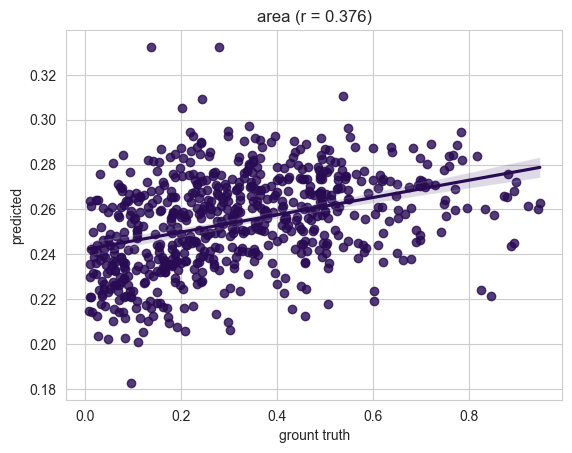

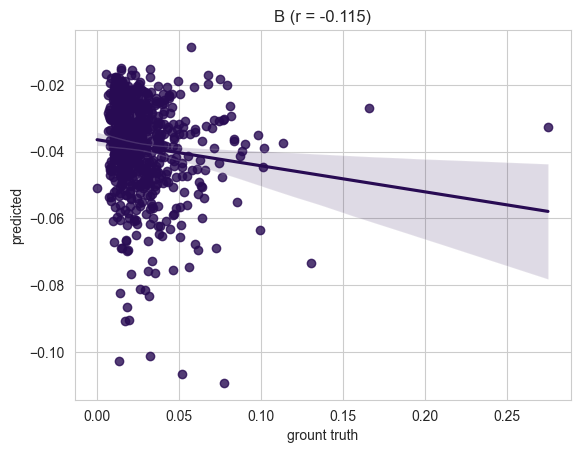

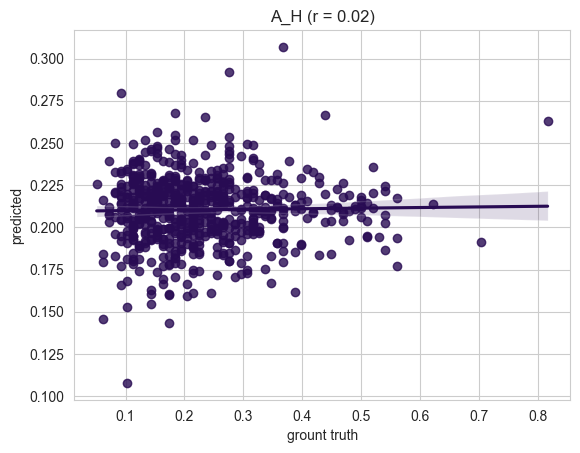

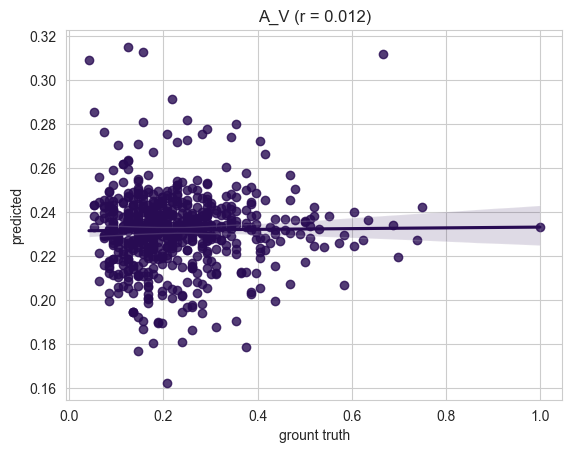

In [184]:
# Plot scatterplots

for feature in ['area', 'B', 'A_H', 'A_V']:
    x = predictions_df_resnet[feature]
    y = predictions_df_resnet['prediction_' + feature]
    ax = sns.regplot(data=predictions_df_resnet, x=feature, y='prediction_' + feature)
    plt.title(feature + " (r = " + str(round((np.corrcoef(x, y)[0, 1]), 3)) + ")")
    plt.xlabel("grount truth")
    plt.ylabel("predicted")
    plt.show()

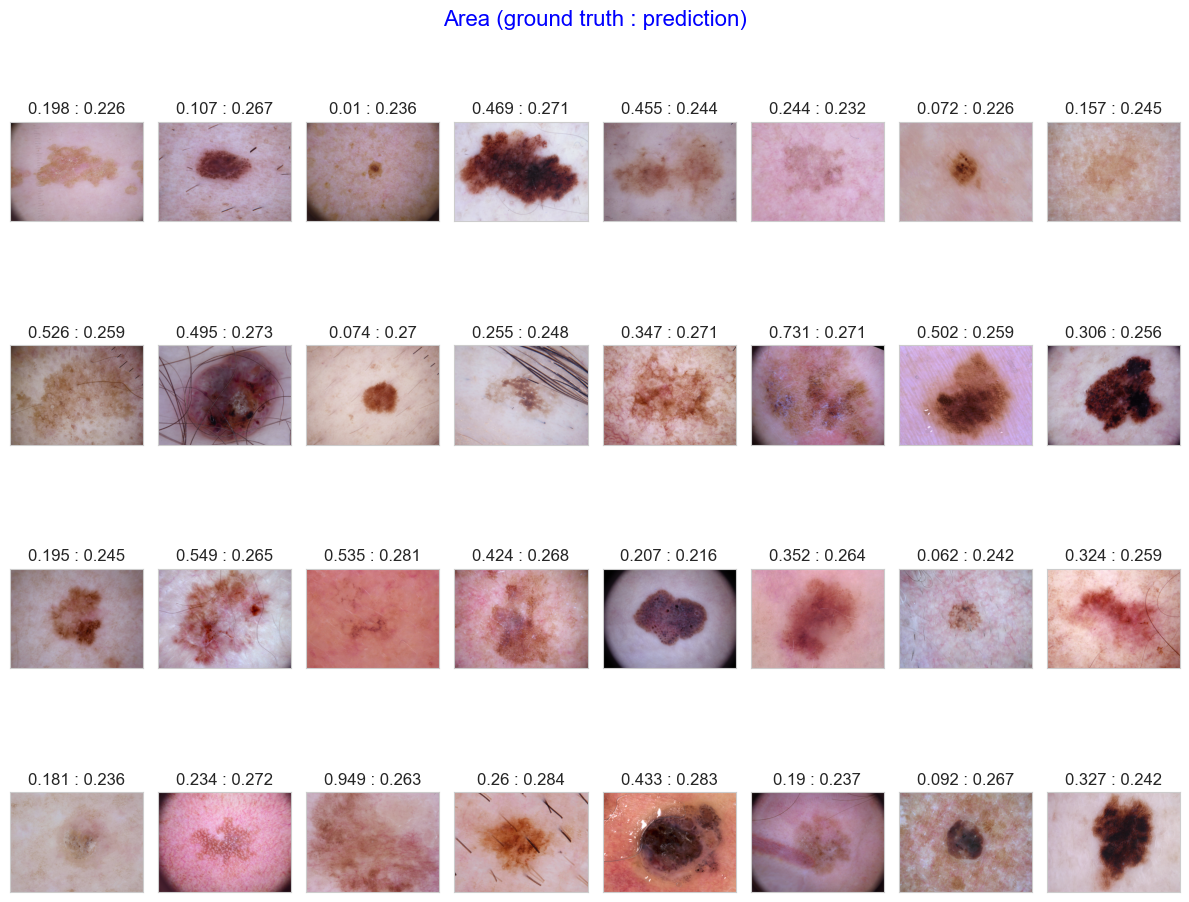

In [245]:
random_selection = predictions_df_resnet.sample(32).reset_index()

# display 16 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    image = cv2.imread(all_lesions_dir + str(random_selection.iloc[[i]]['image'].item()))
    image = image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'{round(random_selection.iloc[[i]]['area'].item(), 3)}' + ' : ' + f'{round(random_selection.iloc[[i]]['prediction_area'].item(), 3)}')
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Area (ground truth : prediction)',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()

## Previous iterations of deep learning model
### Code below is messy and not well documented. 

### No Augmentation old model (did not work)

In [35]:
# Adapted from https://www.kaggle.com/code/amanabdullayev/age-prediction-from-photo-using-cnn-resnet50

#necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import warnings
from keras import layers
from keras.models import Model

In [11]:
# load labels.csv and observe it
labels = pd.read_csv(all_labels_dir + 'labels.csv', index_col=0)
# labels = labels[['image', 'area']]
labels['image'] = [x[:-4] + '.jpg' for x in labels['image']]
labels.head()

,area,centroid,perimeter,B,D1,D2,A,A_H,A_V,image
0,57725,"[319, 220]",1070,1.58,356,244,0.046327,0.20,0.34,ISIC_0024420.jpg
1,67873,"[238, 212]",1038,1.26,351,272,0.015032,0.18,0.17,ISIC_0030333.jpg
2,100696,"[297, 219]",1359,1.46,393,265,0.016195,0.19,0.08,ISIC_0034141.jpg
3,126323,"[296, 232]",1426,1.28,530,342,0.013401,0.15,0.11,ISIC_0029676.jpg
4,107520,"[299, 237]",1349,1.35,425,335,0.026044,0.24,0.20,ISIC_0026545.jpg


/var/folders/sy/76hj9jm13334_1xqh0j2pbnm0000gn/T/ipykernel_38803/3830046918.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(labels['B'], rug=True, kde_kws={'shade':True, 'color':'r'})
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


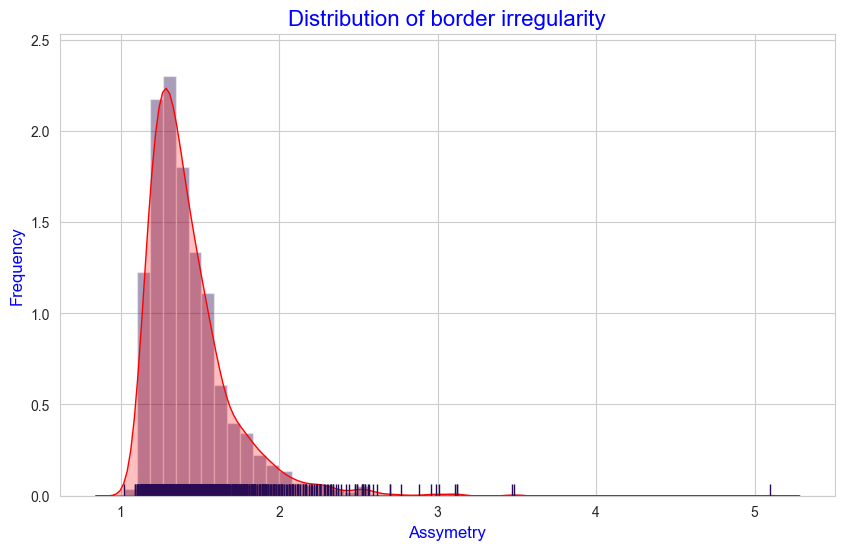

In [15]:
# Plot label
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(labels['B'], rug=True, kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Assymetry', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of border irregularity', fontsize=16, color='b')
plt.show()

In [41]:
# create datagenerator object for training and validation datasets
#rescale images using 1/255
train_datagen = ImageDataGenerator(
            #we will do normalization for image pixel values as following
            rescale=1 / 255
            )

#use flow_from_dataframe method to load images from directory and labels from dataframe
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = labels,
    directory= all_lesions_dir,
    x_col="image", 
    y_col="area",
    #we are doing regression, so we will assign class_mode to 'raw'
    class_mode="raw",
    #to convert all images to same pixel size, for neural networks, all images should have similar size
    target_size=(224,224),
    #we will load images batch by batch (every time 32 images will be loaded)
    batch_size=32,
    seed=12345,
    )

Found 2208 validated image filenames.


In [43]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'all_labels/labels.csv', index_col=0)
    labels['image'] = [x[:-4] + '.jpg' for x in labels['image']]
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'all_lesions/',
        x_col="image", 
        y_col="A",
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path + 'all_labels/labels.csv', index_col=0)
    labels['image'] = [x[:-4] + '.jpg' for x in labels['image']]
    
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_gen_flow = validation_datagen.flow_from_dataframe(
    dataframe=labels,
    directory= path + 'all_lesions/',
    x_col="image", 
    y_col="A",
    class_mode="raw", 
    target_size=(224,224), 
    batch_size=32,
    subset = "validation",
    seed=12345,
    )

    return test_gen_flow


def create_model(input_shape):
    
    """
    It defines the model
    """
    # we will use ResNet50 architecture, with freezing top layers
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    
    #now we will add our custom layers
    #without drop layer, neural networks can easily overfit
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    
    #final layer, since we are doing regression we will add only one neuron (unit)
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=0.0003)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    print(model.summary())

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, 
              epochs=epochs, steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, verbose=2)

    return model

In [44]:
#assign data directory
path = data_in

In [45]:
#load training and testing (actually this is validation data set)
train_data = load_train(path)
test_data = load_test(path)

#build a model
model = create_model(input_shape = (224, 224, 3))

Found 1656 validated image filenames.
Found 552 validated image filenames.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [46]:
#train the model
model = train_model(model, train_data, test_data, epochs = 4)

Epoch 1/4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 - 165s - 3s/step - loss: 0.0593 - mae: 0.0594 - val_loss: 0.0372 - val_mae: 0.0380
Epoch 2/4
52/52 - 151s - 3s/step - loss: 0.0382 - mae: 0.0383 - val_loss: 0.0376 - val_mae: 0.0380
Epoch 3/4
52/52 - 154s - 3s/step - loss: 0.0382 - mae: 0.0383 - val_loss: 0.0372 - val_mae: 0.0380
Epoch 4/4
52/52 - 153s - 3s/step - loss: 0.0383 - mae: 0.0383 - val_loss: 0.0381 - val_mae: 0.0380


In [47]:
model.predict(train_data)

52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 523ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

### Deep Learning Model without ResNet (youtube: https://www.youtube.com/watch?v=9AnCNBL8c6Q)
####  No data normalization - could not interpret results

In [51]:
# load labels.csv and observe it
labels = pd.read_csv(all_labels_dir + 'labels.csv', index_col=0)
labels = labels[['image', 'area']]
labels['image'] = [x[:-4] + '.jpg' for x in labels['image']]
labels.head()

,image,area
0,ISIC_0024420.jpg,57725
1,ISIC_0030333.jpg,67873
2,ISIC_0034141.jpg,100696
3,ISIC_0029676.jpg,126323
4,ISIC_0026545.jpg,107520


In [52]:
train_df, test_df = train_test_split(labels, train_size=0.7, shuffle=True, random_state=1234)

In [53]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [55]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    directory= all_lesions_dir,
    x_col = 'image',
    y_col = 'area',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=1234,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    directory= all_lesions_dir,
    x_col = 'image',
    y_col = 'area',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=1234,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df,
    directory= all_lesions_dir,
    x_col = 'image',
    y_col = 'area',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 1236 validated image filenames.
Found 309 validated image filenames.
Found 663 validated image filenames.


In [69]:
inputs = tf.keras.Input(shape=(120,120,3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3 ), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3 ), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mse'
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - loss: 10277551104.0000 - val_loss: 10566377472.0000
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 10746862592.0000 - val_loss: 10511768576.0000
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - loss: 9887843328.0000 - val_loss: 9180700672.0000
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - loss: 8170472960.0000 - val_loss: 4484333056.0000
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - loss: 3907793408.0000 - val_loss: 3065567744.0000
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - loss: 3296994560.0000 - val_loss: 3109747968.0000
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - loss: 3211998976.0000 - val_loss: 3040651776.0000
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - loss: 3261316864.0000 - val_loss: 3180979712.0000
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 3300083968.0000 - val_loss: 3107142400.0000
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 3

In [75]:
from sklearn.metrics import r2_score

predicted_area = np.squeeze(model.predict(test_images))
true_ages = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_ages, predicted_area)
print("Test R^2 Score: {:.5f}".format(r2))

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step
Test RMSE: 57733.80015
Test R^2 Score: -0.09929


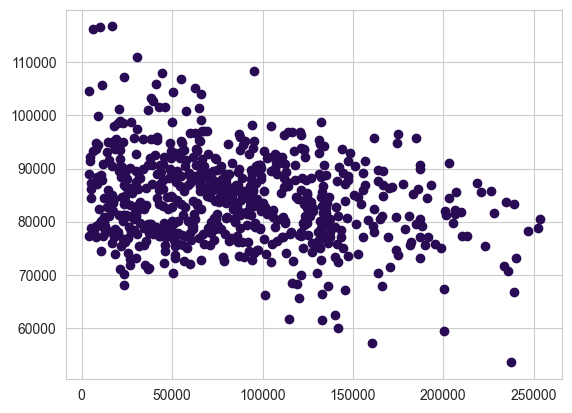

In [77]:
plt.scatter(true_ages, predicted_area)

In [79]:
predictions = test_df.copy()

In [83]:
predictions['prediction'] = predicted_area
predictions['abs_error'] = abs(predictions.area-predictions.prediction)

In [85]:
predictions.sort_values(by='abs_error')

,image,area,prediction,abs_error
622,ISIC_0028898.jpg,92659,92754.554688,95.554688
141,ISIC_0030318.jpg,80633,80883.757812,250.757812
555,ISIC_0024494.jpg,95535,95279.171875,255.828125
2068,ISIC_0026239.jpg,94464,93857.195312,606.804688
374,ISIC_0028792.jpg,88844,88183.289062,660.710938
...,...,...,...,...
1417,ISIC_0033440.jpg,246837,78321.343750,168515.656250
434,ISIC_0031410.jpg,239229,66733.242188,172495.757812
1824,ISIC_0032116.jpg,253303,80541.992188,172761.007812
352,ISIC_0026378.jpg,252302,78743.250000,173558.750000


In [120]:
labels_all = pd.read_csv(all_labels_dir + 'labels.csv', index_col=0)
labels_all['image'] = [x[:-4] + '.jpg' for x in labels_all['image']]

/var/folders/sy/76hj9jm13334_1xqh0j2pbnm0000gn/T/ipykernel_1469/3215418297.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(labels_all['A_V'], rug=True, kde_kws={'shade':True, 'color':'r'})
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


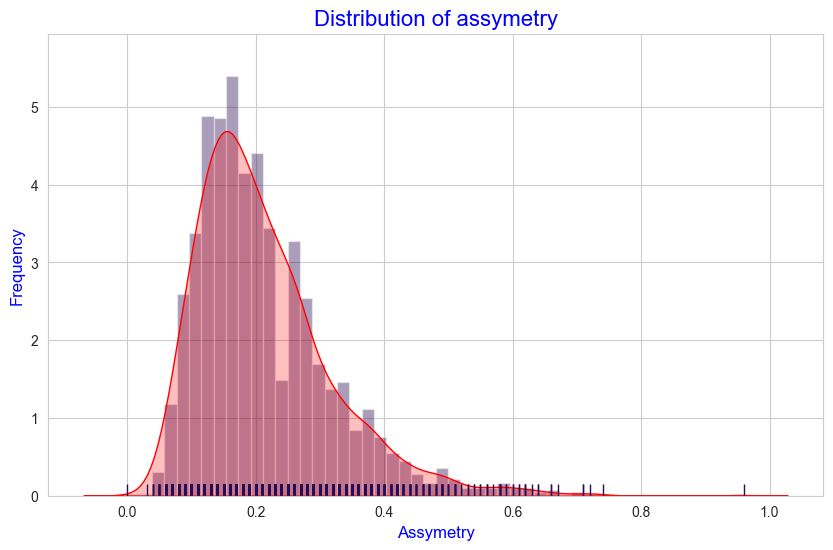

In [125]:
# Plot label
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(labels_all['A_V'], rug=True, kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Assymetry', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of assymetry', fontsize=16, color='b')
plt.show()

### No Normalization #2

In [1]:
features_to_predict = ['area', 'A_H', 'A_V', 'B']

# load labels.csv and observe it
labels_all = pd.read_csv(all_labels_dir + 'labels.csv', index_col=0)
labels_all['image'] = [x[:-4] + '.jpg' for x in labels_all['image']]


# for label_name in features_to_predict:
#     labels = labels_all[['image', label_name]]
    
train_df, test_df = train_test_split(labels_all, train_size=0.7, shuffle=True, random_state=1234)

predictions_df = test_df.copy()

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)

for feature_name in features_to_predict:
    train_images = train_generator.flow_from_dataframe(
        dataframe = train_df,
        directory= all_lesions_dir,
        x_col = 'image',
        y_col = feature_name,
        target_size=(120, 120),
        color_mode='grayscale',
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=1234,
        subset='training'
    )
    
    val_images = train_generator.flow_from_dataframe(
        dataframe = train_df,
        directory= all_lesions_dir,
        x_col = 'image',
        y_col = feature_name,
        target_size=(120, 120),
        color_mode='grayscale',
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=1234,
        subset='validation'
    )
    
    test_images = test_generator.flow_from_dataframe(
        dataframe = test_df,
        directory= all_lesions_dir,
        x_col = 'image',
        y_col = feature_name,
        target_size=(120, 120),
        color_mode='grayscale',
        class_mode='raw',
        batch_size=32,
        shuffle=False
    )

    inputs = tf.keras.Input(shape=(120,120,1))
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3 ), activation='relu')(inputs)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3 ), activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer='adam',
        loss='mse'
    )
    
    history = model.fit(
        train_images,
        validation_data=val_images,
        epochs=100,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
        ]
    )

    
    predictions = np.squeeze(model.predict(test_images))
    true_labels = test_images.labels
    
    rmse = np.sqrt(model.evaluate(test_images, verbose=0))
    print(feature_name + ":")
    print("Test RMSE: {:.5f}".format(rmse))
    
    r2 = r2_score(true_labels, predictions)
    print("Test R^2 Score: {:.5f}".format(r2))

    prediction_column = 'prediction_' + feature_name
    predictions_df[prediction_column] = predictions
    predictions_df['error_' + feature_name] = abs(predictions_df[feature_name]-predictions_df[prediction_column])

In [ ]:
predictions_df[['B', 'prediction_B', 'error_B']]

### Normalized labels between 0 and 1

In [134]:
features_to_predict = ['area', 'A_H', 'A_V', 'B']

# load labels.csv and observe it
labels_all = pd.read_csv(all_labels_dir + 'labels.csv', index_col=0)
labels_all['image'] = [x[:-4] + '.jpg' for x in labels_all['image']]



for label_name in features_to_predict:
    labels_all[label_name]=(labels_all[label_name]-labels_all[label_name].min())/(labels_all[label_name].max()-labels_all[label_name].min())
    # labels = labels_all[['image', label_name]]

# labels_all
                                                                                  
train_df, test_df = train_test_split(labels_all, train_size=0.7, shuffle=True, random_state=1234)

predictions_df_norm = test_df.copy()

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)

for feature_name in features_to_predict:
    train_images = train_generator.flow_from_dataframe(
        dataframe = train_df,
        directory= all_lesions_dir,
        x_col = 'image',
        y_col = feature_name,
        target_size=(120, 120),
        color_mode='grayscale',
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=1234,
        subset='training'
    )
    
    val_images = train_generator.flow_from_dataframe(
        dataframe = train_df,
        directory= all_lesions_dir,
        x_col = 'image',
        y_col = feature_name,
        target_size=(120, 120),
        color_mode='grayscale',
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=1234,
        subset='validation'
    )
    
    test_images = test_generator.flow_from_dataframe(
        dataframe = test_df,
        directory= all_lesions_dir,
        x_col = 'image',
        y_col = feature_name,
        target_size=(120, 120),
        color_mode='grayscale',
        class_mode='raw',
        batch_size=32,
        shuffle=False
    )

    inputs = tf.keras.Input(shape=(120,120,1))
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3 ), activation='relu')(inputs)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3 ), activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer='adam',
        loss='mse'
    )
    
    history = model.fit(
        train_images,
        validation_data=val_images,
        epochs=100,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
        ]
    )

    
    predictions = np.squeeze(model.predict(test_images))
    true_labels = test_images.labels
    
    rmse = np.sqrt(model.evaluate(test_images, verbose=0))
    print(feature_name + ":")
    print("Test RMSE: {:.5f}".format(rmse))
    
    r2 = r2_score(true_labels, predictions)
    print("Test R^2 Score: {:.5f}".format(r2))

    prediction_column = 'prediction_' + feature_name
    predictions_df_norm[prediction_column] = predictions
    predictions_df_norm['error_' + feature_name] = abs(predictions_df_norm[feature_name]-predictions_df_norm[prediction_column])

Found 1236 validated image filenames.
Found 309 validated image filenames.
Found 663 validated image filenames.
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 0.0927 - val_loss: 0.0422
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 0.0459 - val_loss: 0.0404
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - loss: 0.0406 - val_loss: 0.0406
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - loss: 0.0426 - val_loss: 0.0403
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - loss: 0.0396 - val_loss: 0.0366
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - loss: 0.0401 - val_loss: 0.0353
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 0.0398 - val_loss: 0.0335
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 0.0381 - val_loss: 0.0348
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 0.0370 - val_loss: 0.0337
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - loss: 0.0353 - val_loss: 0.0346
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - loss: 0.0348 - val_loss: 0.0325
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 0.0358 - val_loss: 0.0144
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 0.0129 - val_loss: 0.0128
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 0.0117 - val_loss: 0.0132
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.0112 - val_loss: 0.0126
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.0130 - val_loss: 0.0127
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.0123 - val_loss: 0.0133
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.0122 - val_loss: 0.0129
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - loss: 0.0106 - val_loss: 0.0125
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - loss: 0.0122 - val_loss: 0.0127
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.0121 - val_loss: 0.0123
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0131 - val_loss: 0.0125
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 0.0214 - val_loss: 0.0118
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.0110 - val_loss: 0.0115
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - loss: 0.0114 - val_loss: 0.0124
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0118 - val_loss: 0.0113
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0110 - val_loss: 0.0117
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - loss: 0.0046 - val_loss: 0.0060
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - loss: 0.0044 - val_loss: 0.0060
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.0043 - val_loss: 0.0059
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0037 - val_loss: 0.0059
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - loss: 0.0039 - val_loss: 0.0060
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 0.0043 - val_loss: 0.0060
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 0.0042 - val_loss: 0.0060
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - loss: 0.0040 - val_loss: 0.0058
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step

### Deep Learning Model initial attempt asymmetry

In [88]:
# load labels.csv and observe it
labels = pd.read_csv(all_labels_dir + 'labels.csv', index_col=0)
labels = labels[['image', 'A_H']]
labels['image'] = [x[:-4] + '.jpg' for x in labels['image']]
labels.head()

,image,A_H
0,ISIC_0024420.jpg,0.20
1,ISIC_0030333.jpg,0.18
2,ISIC_0034141.jpg,0.19
3,ISIC_0029676.jpg,0.15
4,ISIC_0026545.jpg,0.24


/var/folders/sy/76hj9jm13334_1xqh0j2pbnm0000gn/T/ipykernel_1469/1126241837.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(labels['A_H'], rug=True, kde_kws={'shade':True, 'color':'r'})
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


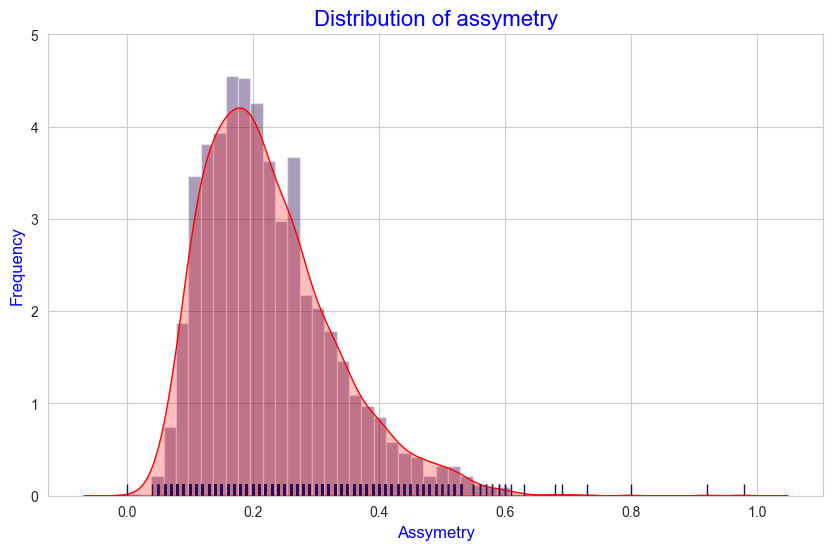

In [89]:
# Plot label
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(labels['A_H'], rug=True, kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Assymetry', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of assymetry', fontsize=16, color='b')
plt.show()

In [90]:
train_df, test_df = train_test_split(labels, train_size=0.7, shuffle=True, random_state=1234)

In [92]:
# def to_grayscale_then_rgb(image):
#     image = tf.image.rgb_to_grayscale(image)
#     return image

In [97]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2,
    # preprocessing_function=to_grayscale_then_rgb
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    # preprocessing_function=to_grayscale_then_rgb
)

In [98]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    directory= all_lesions_dir,
    x_col = 'image',
    y_col = 'A_H',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=1234,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    directory= all_lesions_dir,
    x_col = 'image',
    y_col = 'A_H',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=1234,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df,
    directory= all_lesions_dir,
    x_col = 'image',
    y_col = 'A_H',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 1236 validated image filenames.
Found 309 validated image filenames.
Found 663 validated image filenames.


In [114]:
inputs = tf.keras.Input(shape=(120,120,1))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3 ), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3 ), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mse'
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

In [104]:
predicted_area = np.squeeze(model.predict(test_images))
true_area = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_ages, predicted_area)
print("Test R^2 Score: {:.5f}".format(r2))

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step
Test RMSE: 0.10939
Test R^2 Score: -0.01742


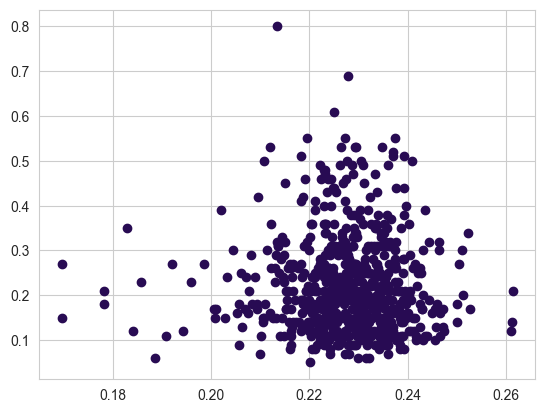

In [105]:
plt.scatter(predicted_area, true_area)

In [106]:
predictions_A_H = test_df.copy()

In [110]:
predictions_A_H['prediction'] = predicted_area
predictions_A_H['abs_error'] = abs(predictions_A_H.A_H-predictions_A_H.prediction)

In [113]:
predictions_A_H.sort_values(by='abs_error')[300:310]

,image,A_H,prediction,abs_error
1440,ISIC_0026844.jpg,0.17,0.236742,0.066742
634,ISIC_0029576.jpg,0.29,0.223251,0.066749
1509,ISIC_0024883.jpg,0.17,0.236881,0.066881
903,ISIC_0029014.jpg,0.16,0.227186,0.067186
879,ISIC_0024900.jpg,0.17,0.237242,0.067242
768,ISIC_0030795.jpg,0.17,0.238204,0.068204
1468,ISIC_0030564.jpg,0.30,0.231594,0.068406
255,ISIC_0031013.jpg,0.16,0.229860,0.069860
1184,ISIC_0026314.jpg,0.18,0.250117,0.070117
519,ISIC_0026596.jpg,0.16,0.230491,0.070491


### Deep Learning Model augmentation

In [51]:
# load labels.csv and observe it
labels = pd.read_csv(all_labels_dir + 'labels.csv', index_col=0)
labels = labels[['image', 'area']]
labels['image'] = [x[:-4] + '.jpg' for x in labels['image']]
labels.head()

,image,area
0,ISIC_0024420.jpg,57725
1,ISIC_0030333.jpg,67873
2,ISIC_0034141.jpg,100696
3,ISIC_0029676.jpg,126323
4,ISIC_0026545.jpg,107520


In [52]:
train_df, test_df = train_test_split(labels, train_size=0.7, shuffle=True, random_state=1234)

In [53]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [55]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    directory= all_lesions_dir,
    x_col = 'image',
    y_col = 'area',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=1234,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    directory= all_lesions_dir,
    x_col = 'image',
    y_col = 'area',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=1234,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df,
    directory= all_lesions_dir,
    x_col = 'image',
    y_col = 'area',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 1236 validated image filenames.
Found 309 validated image filenames.
Found 663 validated image filenames.


In [69]:
inputs = tf.keras.Input(shape=(120,120,3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3 ), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3 ), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mse'
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - loss: 10277551104.0000 - val_loss: 10566377472.0000
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 10746862592.0000 - val_loss: 10511768576.0000
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - loss: 9887843328.0000 - val_loss: 9180700672.0000
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - loss: 8170472960.0000 - val_loss: 4484333056.0000
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - loss: 3907793408.0000 - val_loss: 3065567744.0000
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - loss: 3296994560.0000 - val_loss: 3109747968.0000
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - loss: 3211998976.0000 - val_loss: 3040651776.0000
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - loss: 3261316864.0000 - val_loss: 3180979712.0000
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 3300083968.0000 - val_loss: 3107142400.0000
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 3

In [75]:
from sklearn.metrics import r2_score

predicted_area = np.squeeze(model.predict(test_images))
true_ages = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_ages, predicted_area)
print("Test R^2 Score: {:.5f}".format(r2))

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step
Test RMSE: 57733.80015
Test R^2 Score: -0.09929


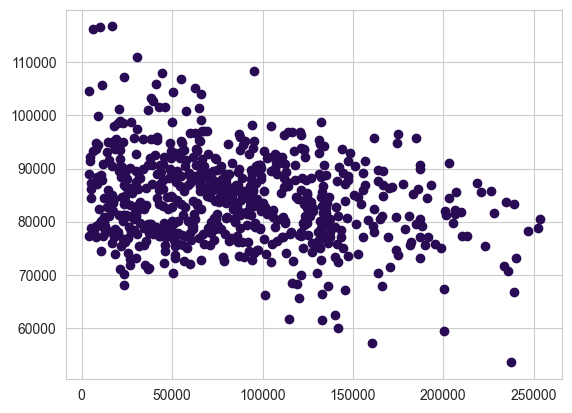

In [77]:
plt.scatter(true_ages, predicted_area)

In [79]:
predictions = test_df.copy()

In [83]:
predictions['prediction'] = predicted_area
predictions['abs_error'] = abs(predictions.area-predictions.prediction)

In [85]:
predictions.sort_values(by='abs_error')

,image,area,prediction,abs_error
622,ISIC_0028898.jpg,92659,92754.554688,95.554688
141,ISIC_0030318.jpg,80633,80883.757812,250.757812
555,ISIC_0024494.jpg,95535,95279.171875,255.828125
2068,ISIC_0026239.jpg,94464,93857.195312,606.804688
374,ISIC_0028792.jpg,88844,88183.289062,660.710938
...,...,...,...,...
1417,ISIC_0033440.jpg,246837,78321.343750,168515.656250
434,ISIC_0031410.jpg,239229,66733.242188,172495.757812
1824,ISIC_0032116.jpg,253303,80541.992188,172761.007812
352,ISIC_0026378.jpg,252302,78743.250000,173558.750000
